In [1]:
import numpy as np
from enum import Enum
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import copy
import time

In [2]:
#Vamos a implementar esta nueva versión con direcciones a ver que tal funciona
Decisions = {}
Decisions['UP'] = 0
Decisions['DOWN'] = 1
Decisions['RIGHT'] = 2
Decisions['LEFT'] = 3
Decisions['LIFT_TREASURE'] = 4
Decisions['NOTHING'] = 5
Decisions['RANDOM_DIR'] = 6

CellType = {}
CellType['EMPTY'] = 0
CellType['TREASURE'] = 1
CellType['WALL'] = 2

In [3]:
class MightyTraveler:
    def __init__(self):
        numberOfGenes = 3**(5)
        #Vamos a tener 243 genes cada uno me va a decir la estrategia a tomar para el caso especifico
        self.position = np.zeros(2)
        self.directions = np.array([[1,0],[-1,0],[0,1],[0,-1]])
    
    def setGenotype(self, genotype):
        self.genotype = genotype
    
    #Aquí surroundings se va a pasar como un arreglo 
    #el cual tendrá 5 posiciones N S E O C
    
    def move(self,surroundings):
        index = 0
        for i in range(0,5):
            index += surroundings[i]*(3**(i))
        prevPos = []
        prevPos.append(self.position[0])
        prevPos.append(self.position[1])
        index = int(index)
        decision = self.genotype[index]
        #Up
        if(decision == 0):
            self.position[1] += 1
        #Down
        elif(decision == 1):
            self.position[1] -= 1
        #Right
        elif(decision == 2):
            self.position[0] += 1
        #Left
        elif(decision == 3):
            self.position[0] -= 1
        #Random
        elif(decision == 6):
            self.position += random.choice(self.directions)
        #Else we do nothing
        return decision, prevPos

In [4]:
class Map:
    
    #Vamos a inicializar el mapa con el ancho y largo que nos proporcione el usuario
    def __init__(self,width:int,height:int):
        self.width = width
        self.height = height
        self.region = np.zeros((self.height,self.width))
        self.posTilesX = range(1,self.width-2)
        self.posTilesY = range(1,self.height-2)
        #Ponemos las paredes
        for i in range(0,width):
            self.region[0,i] = 2
            self.region[height-1,i] = 2
        for i in range(0,height):
            self.region[i,0] = 2
            self.region[i,width-1] = 2
    
    #Colocamos aleatoriamente algunos tesoros
    def placeTreasures(self,n):
        objectsPlaced = 0
        treasuresPositions = np.zeros((n,2))
        while(objectsPlaced < n):
            #Elegimos una posición aleatoria para el objeto a colocar
            randX = random.choice(self.posTilesX)
            randY = random.choice(self.posTilesY)
            #Nos aseguramos de que 1.- no haya una pared en la posición y 2.-No haya un objeto ya colocado ahi
            
            if(self.region[randY,randX] == 0):
                self.region[randY,randX] = 1
                treasuresPositions[objectsPlaced,:]  = [randX,randY]
                objectsPlaced += 1
        self.treasuresPositions = treasuresPositions
        self.numTreasures = n
    
    def resetTreasures(self):
        for i in range(0,self.numTreasures):
            treasure = self.treasuresPositions[i,:]
            self.region[int(treasure[1]),int(treasure[0])] = 1
    
    def getSurroundings(self,posX,posY):
        x = int(posX)
        y = int(self.height-1-posY)
        surroundings = [self.region[y-1,x],self.region[y+1,x],self.region[y,x+1],self.region[y,x-1],self.region[y,x]]
        return surroundings
    
    def getCellType(self,posX,posY):
        x = int(posX)
        y = int(self.height-1-posY)
        
        return self.region[y,x]
    
    def takeCellOut(self,posX,posY):
        x = int(posX)
        y = int(self.height-posY-1)
        self.region[y,x] = 0
    
    
    

class MapArtist:
    #m es un mapa con el cual se inicializa al artista
    def __init__(self,m):
        self.map = m
        self.wallColor = "#EC3E18"
        self.emptySpaceColor = "#BFAB7A"
        self.treasureColor = "#FFE614"
        self.tileSize = 10
        
    #Receives an axis, clears it and draws a map
    def drawMap(self,ax):
        ax.clear()
        gridX = np.linspace(0,self.map.width*self.tileSize,self.map.width)
        gridY = np.linspace(0,self.map.height*self.tileSize,self.map.height)
        for i in range(0,self.map.width):
            for j in range(0,self.map.height):
                xCorner = gridX[i]
                yCorner = gridY[j]
                cellType = self.map.getCellType(i,j)
                #Pinta todas las celdas con su color adecuado
                #Pared
                if(cellType == 2):
                    rect = patches.Rectangle((xCorner,yCorner),self.tileSize,self.tileSize,fill = True, edgecolor = self.wallColor, facecolor = self.wallColor) 
                #Celda vacia    
                elif(cellType == 0):
                    rect = patches.Rectangle((xCorner,yCorner),self.tileSize,self.tileSize,fill = True, edgecolor = self.emptySpaceColor, facecolor = self.emptySpaceColor)
                #Tesoro
                elif(cellType == 1):
                    rect = patches.Rectangle((xCorner,yCorner),self.tileSize,self.tileSize,fill = True, edgecolor = self.treasureColor, facecolor = self.treasureColor)
                ax.add_patch(rect)
    def getDrawingWidth(self):
        return self.map.width*self.tileSize + self.tileSize
    def getDrawingHeight(self):
        return self.map.height*self.tileSize + self.tileSize
    
    def setMap(self,stage):
        self.map.region = stage
        

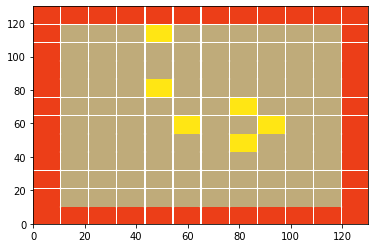

In [5]:
#Probamos el dibujado del mapa
stage = Map(12,12)
stage.placeTreasures(6)
artist = MapArtist(stage)
fig,ax = plt.subplots()
artist.drawMap(ax)
plt.ylim([0,artist.getDrawingHeight()])
plt.xlim([0,artist.getDrawingWidth()])
plt.show()

In [6]:
#Vamos a implementar la clase GameMaster que va a conducir experimentos con sus marionetas los viajeros busca tesoros.

class PuppetMaster:
    
    def __init__(self):
        self.fig,self.ax = plt.subplots()
    
    
    def play(self,puppet,stage,steps):
        #Colocamos al puppet en medio del tablero
        puppet.position = np.array([np.floor(stage.width/2),np.floor(stage.height/2)])
        score = 0
        for i in range(0,steps):
            position = puppet.position
            #start = time.time()
            surroundings = stage.getSurroundings(position[0],position[1])
            #end = time.time()
            #print("surreoundings time "+str(end-start))
            #start = time.time()
            decision,prevPos = puppet.move(surroundings)
            #end = time.time()
            #print("movement time "+str(end-start))
            newPos = puppet.position
            #Si decide moverse hacia una pared entonces lo penalizamos y lo regresamos a la posición donde estaba
            if(decision == 0 or decision == 1 or decision == 2 or decision == 3 or decision == 6):
                cellType = stage.getCellType(newPos[0],newPos[1])
                #If we hit a wall
                if(cellType == 2):
                    puppet.position = prevPos
                    score  -= 1
            #If lift treasure
            elif(decision == 4):
                cellType = stage.getCellType(newPos[0],newPos[1])
                #If there is a treasure
                if(cellType == 1):
                    stage.takeCellOut(newPos[0],newPos[1])
                    score += 10
                #If there is no treasure
                elif(cellType == 0):
                    #print("treasure lifted incorrectly")
                    score -= 3
        return score
    
    def playRun(self,puppet,stage,steps):
        positions = np.zeros((steps,2))
        maps = np.zeros((stage.height,stage.width,steps))
        #Colocamos al puppet en medio del tablero
        puppet.position = np.array([np.floor(stage.width/2),np.floor(stage.height/2)])
        score = 0
        for i in range(0,steps):
            position = puppet.position
            surroundings = stage.getSurroundings(position[0],position[1])
            decision,prevPos = puppet.move(surroundings)
            newPos = puppet.position
            positions[i,:] = newPos
            #Si decide moverse hacia una pared entonces lo penalizamos y lo regresamos a la posición donde estaba
            if(decision == Decisions['UP'] or decision == Decisions['DOWN'] or decision == Decisions['LEFT'] or decision == Decisions['RIGHT'] or decision == Decisions['RANDOM_DIR']):
                newPosition = puppet.position
                if(stage.getCellType(newPosition[0],newPosition[1]) == CellType['WALL']):
                    puppet.position = prevPos
                    score  -= 1
            elif(decision == Decisions['LIFT_TREASURE']):
                if(stage.getCellType(newPos[0],newPos[1]) == CellType['TREASURE']):
                    stage.takeCellOut(newPos[0],newPos[1])
                    score += 10
                elif(stage.getCellType(newPos[0],newPos[1]) == CellType['EMPTY']):
                    #print("Lifted incorrectly")
                    score -= 3
            maps[:,:,i] = stage.region
        
        return [maps, positions, score]
    
    
    def plotMap(self,i):
        pos = self.positions[i,:]
        self.mapHolder.setMap(self.maps[:,:,i])
        self.mapHolder.drawMap(self.ax)
        self.ax.plot(self.mapHolder.tileSize+pos[0]*self.mapHolder.tileSize,pos[1]*self.mapHolder.tileSize+self.mapHolder.tileSize,marker = 'o',markersize = 5)
        
    def obtainPlayAnimation(self,puppet,stage,steps):
        [self.maps,self.positions,self.score] = self.playRun(puppet,stage,steps)
        print(self.score)
        self.mapHolder = MapArtist(Map(stage.width, stage.height))
        anim = FuncAnimation(self.fig, self.plotMap, frames = steps, interval = 50, blit = False)
        return HTML(anim.to_html5_video())
        
        
    
    
                    
            
            
            
            
        
        
        
        

0


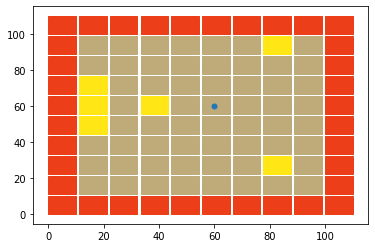

In [7]:
#Prueba del puppet master
puppet = MightyTraveler()
#Inicializamos aleatoriamente un genotipo 

genotype = np.zeros((3**5,1))
#
decisions = [0,1,2,3,4,5,6]

for i in range(0,3**5):
    genotype[i] = random.choice(decisions)
    
puppet.setGenotype(genotype)

#Ahora inicializamos el mapa
stage = Map(10,10)
stage.placeTreasures(6)
#Creamos un master of puppets para jugar con nuestro mapa y caminante
master = PuppetMaster()
master.obtainPlayAnimation(puppet,stage,100)

#print(master.score)


    

In [13]:
#Ok, parece estar funcionando 
#Ahora si crearemos nuestra clase para realizar los experimentos genéticos


class Darwin:
    
    def __init__(self,nMaps,mapSize,nTreasures):
        self.puppetMaster = PuppetMaster()
        self.maps = []
        self.nMaps = nMaps
        self.mapSize = mapSize
        self.nTreasures = nTreasures
        for i in range(0,nMaps):
            m = Map(mapSize,mapSize)
            m.placeTreasures(nTreasures)
            self.maps.append(m)
        self.mutationProbability = 0.01
        self.numberOfMutations = 10
        self.decisions = [0,1,2,3,4,5,6]
        self.thresholdForGoatInclusion = 50
    
    
    #Función de inicialización de la población 
    def initializePopulation(self, populationSize):
        #start = time.time()
        population = []
        for i in range(0,populationSize):
            puppet = MightyTraveler()
            puppet.setGenotype(np.array(random.choices(self.decisions,k = 3**5)))
            population.append(puppet)
        self.population = population
        self.populationSize = populationSize
        #end = time.time()
        #print("Initialization time "+str(end-start))
    #Función para evaluar a la población
    
    def evaluatePopulation(self,steps,maps):
        #start = time.time()
        scores = np.zeros(self.populationSize)
        #Jugamos en cada mapa
        for j in range(0,len(maps)):
            for i in range(0,self.populationSize):
                maps[j].resetTreasures()
                puppet = self.population[i]
                #print(maps[j].region)
                score = self.puppetMaster.play(puppet,maps[j],steps)
                scores[i] += score
        maxScore = np.max(scores)
        index = np.argmax(scores)
        maxPuppet = self.population[index]
        #end = time.time()
        #print("Evaluation time "+str(end-start))
        
        return scores,maxScore,maxPuppet
    
    
    
    def selectPopulation(self, scores, goatScore, goat):
        #start = time.time()
        #Vamos a seleccionar una nueva población
        minScore = np.min(scores)
        maxScore = np.max(scores)
        intervalSize = maxScore - minScore
        if(intervalSize != 0):
            normalizedScores = np.abs(scores-minScore)/intervalSize
            probabilities = normalizedScores/sum(normalizedScores)
            print(minScore)
            print(maxScore)
            
            self.population = random.choices(self.population,weights = probabilities,k = self.populationSize)
        
        else:
            print("common score "+str(maxScore))
            #Hacemos la selección en forma aleatoria
            self.population = random.choices(self.population,k = self.populationSize)
        
        if(goatScore-maxScore > self.thresholdForGoatInclusion):
            minInd = np.argmin(scores)
            self.population[minInd] = goat
            print("GOAT reintroduced")
        #end = time.time()
        #print("Selection time "+str(end-start))
    
    #Vamos a hacer una cruza 
    def crossPopulation(self):
        #start = time.time()
        #Punto de cruza aleatorio
        crossPop  = self.population
        random.shuffle(crossPop)
        crossedPop = []
        i = 0
        while(i <= self.populationSize-2):
            crossPoint = random.randrange(0,3**5)
            child1 = MightyTraveler()
            child2 = MightyTraveler()
            genotype1 = np.zeros(3**5)
            genotype2 = np.zeros(3**5)
            parent1 = crossPop[i]
            parent2 = crossPop[i+1]
            n = len(parent1.genotype)
            genotype1[0:crossPoint+1] = parent1.genotype[0:crossPoint+1]
            genotype1[crossPoint+1:n] = parent2.genotype[crossPoint+1:n]
            genotype2[0:crossPoint+1] = parent2.genotype[0:crossPoint+1]
            genotype2[crossPoint+1:n] = parent1.genotype[crossPoint+1:n]

            child1.setGenotype(genotype1)
            child2.setGenotype(genotype2)
            crossedPop.append(child1)
            crossedPop.append(child2)
            i += 2
        self.population = crossedPop
        #end = time.time()
        #print("crossover time "+str(end-start))
    
    def mutate(self):
        #start = time.time()
        for i in range(0,len(self.population)):
            dice = random.random()
            if(dice < self.mutationProbability):
                indicesToMutate = []
                for j in range(0,self.numberOfMutations):
                    indicesToMutate.append(random.randrange(0,3**5-1))
                
                for j in range(0,self.numberOfMutations):
                    self.population[i].genotype[indicesToMutate[j]] = random.choice(self.decisions)
        #end = time.time()
        #print("evolvetime "+str(end-start))
    
    def evolve(self,generations,steps):
        bestScores = []
        goat = None
        goatScore = float('-inf')
        for i in range(1,generations):
            print("generation "+str(i))
            #Evaluamos a la población
            scores, bestScore,maxPuppet = self.evaluatePopulation(steps,self.maps)
            #Agregamos el mejor puntaje a un arreglo
            bestScores.append(bestScore)
            #Si el goat es el mejor de la historia lo guardamos
            if(bestScore >= goatScore):
                goatScore = bestScore
                goat = maxPuppet
                print("New best score "+str(bestScore))
            #Seleccionamos a la población
            self.selectPopulation(scores,goatScore,goat)
            #Comencemos con un crosspoint a la mitad a ver que tal funciona
            self.crossPopulation()
            self.mutate()
            self.reshuffleMaps()
        return maxPuppet, bestScores,goat, goatScore
    
    def reshuffleMaps(self):
        self.maps = []
        for i in range(0,self.nMaps):
            m = Map(self.mapSize,self.mapSize)
            m.placeTreasures(self.nTreasures)
            self.maps.append(m)
    
    
    
    
       

generation 1
New best score 50.0
-29982.0
50.0
generation 2
New best score 60.0
-29979.0
60.0
generation 3
New best score 60.0
-29985.0
60.0
generation 4
-23994.0
50.0
generation 5
-17986.0
50.0
generation 6
-26976.0
40.0
generation 7
New best score 60.0
-14967.0
60.0
generation 8
New best score 60.0
-20748.0
60.0
generation 9
-11892.0
30.0
generation 10
-8969.0
40.0
generation 11
-29801.0
20.0
generation 12
-14819.0
20.0
generation 13
-7580.0
40.0
generation 14
New best score 70.0
-8973.0
70.0
generation 15
-11964.0
60.0
generation 16
-15770.0
40.0
generation 17
-5997.0
30.0
generation 18
-6917.0
40.0
generation 19
-10740.0
40.0
generation 20
-5997.0
60.0
generation 21
New best score 70.0
-5979.0
70.0
generation 22
-7930.0
30.0
generation 23
-4965.0
50.0
generation 24
-3000.0
30.0
generation 25
-3000.0
50.0
generation 26
-3976.0
60.0
generation 27
-2994.0
50.0
generation 28
-5964.0
20.0
generation 29
-9885.0
30.0
generation 30
-5097.0
40.0
generation 31
-994.0
20.0
generation 32
-5997

20.0
40.0
GOAT reintroduced
generation 221
10.0
30.0
GOAT reintroduced
generation 222
60.0
80.0
GOAT reintroduced
generation 223
20.0
90.0
GOAT reintroduced
generation 224
30.0
90.0
GOAT reintroduced
generation 225
-977.0
70.0
GOAT reintroduced
generation 226
20.0
50.0
GOAT reintroduced
generation 227
20.0
30.0
GOAT reintroduced
generation 228
50.0
100.0
generation 229
-997.0
70.0
GOAT reintroduced
generation 230
40.0
90.0
GOAT reintroduced
generation 231
30.0
50.0
GOAT reintroduced
generation 232
-2945.0
60.0
GOAT reintroduced
generation 233
20.0
60.0
GOAT reintroduced
generation 234
50.0
80.0
GOAT reintroduced
generation 235
60.0
100.0
generation 236
30.0
100.0
generation 237
common score 60.0
GOAT reintroduced
generation 238
30.0
60.0
GOAT reintroduced
generation 239
-2952.0
60.0
GOAT reintroduced
generation 240
-7814.0
70.0
GOAT reintroduced
generation 241
common score 20.0
GOAT reintroduced
generation 242
-939.0
80.0
GOAT reintroduced
generation 243
-2947.0
80.0
GOAT reintroduced


130.0
180.0
GOAT reintroduced
generation 416
108.0
120.0
GOAT reintroduced
generation 417
90.0
160.0
GOAT reintroduced
generation 418
-834.0
180.0
GOAT reintroduced
generation 419
137.0
230.0
generation 420
-842.0
180.0
GOAT reintroduced
generation 421
146.0
170.0
GOAT reintroduced
generation 422
-5801.0
-2822.0
GOAT reintroduced
generation 423
145.0
200.0
generation 424
99.0
160.0
GOAT reintroduced
generation 425
-868.0
190.0
GOAT reintroduced
generation 426
-934.0
127.0
GOAT reintroduced
generation 427
110.0
150.0
GOAT reintroduced
generation 428
127.0
150.0
GOAT reintroduced
generation 429
-886.0
190.0
GOAT reintroduced
generation 430
10.0
130.0
GOAT reintroduced
generation 431
60.0
240.0
generation 432
90.0
170.0
GOAT reintroduced
generation 433
-3870.0
-2836.0
GOAT reintroduced
generation 434
130.0
140.0
GOAT reintroduced
generation 435
100.0
110.0
GOAT reintroduced
generation 436
110.0
170.0
GOAT reintroduced
generation 437
97.0
170.0
GOAT reintroduced
generation 438
90.0
120.0
G

-8860.0
179.0
GOAT reintroduced
generation 605
-8676.0
250.0
generation 606
60.0
120.0
GOAT reintroduced
generation 607
-3802.0
190.0
GOAT reintroduced
generation 608
30.0
160.0
GOAT reintroduced
generation 609
-5729.0
200.0
GOAT reintroduced
generation 610
-5917.0
110.0
GOAT reintroduced
generation 611
-2880.0
169.0
GOAT reintroduced
generation 612
127.0
150.0
GOAT reintroduced
generation 613
-2863.0
136.0
GOAT reintroduced
generation 614
180.0
190.0
GOAT reintroduced
generation 615
202.0
210.0
GOAT reintroduced
generation 616
156.0
216.0
GOAT reintroduced
generation 617
80.0
120.0
GOAT reintroduced
generation 618
120.0
190.0
GOAT reintroduced
generation 619
-2822.0
210.0
GOAT reintroduced
generation 620
89.0
150.0
GOAT reintroduced
generation 621
127.0
219.0
GOAT reintroduced
generation 622
147.0
180.0
GOAT reintroduced
generation 623
157.0
219.0
GOAT reintroduced
generation 624
154.0
170.0
GOAT reintroduced
generation 625
186.0
200.0
GOAT reintroduced
generation 626
-810.0
220.0
GOA

-835.0
170.0
GOAT reintroduced
generation 797
-29891.0
229.0
GOAT reintroduced
generation 798
100.0
200.0
GOAT reintroduced
generation 799
180.0
220.0
GOAT reintroduced
generation 800
-9724.0
220.0
GOAT reintroduced
generation 801
-29891.0
180.0
GOAT reintroduced
generation 802
150.0
200.0
GOAT reintroduced
generation 803
120.0
170.0
GOAT reintroduced
generation 804
136.0
170.0
GOAT reintroduced
generation 805
255.0
300.0
generation 806
-805.0
256.0
GOAT reintroduced
generation 807
119.0
190.0
GOAT reintroduced
generation 808
209.0
287.0
GOAT reintroduced
generation 809
98.0
130.0
GOAT reintroduced
generation 810
184.0
210.0
GOAT reintroduced
generation 811
-2895.0
150.0
GOAT reintroduced
generation 812
160.0
180.0
GOAT reintroduced
generation 813
115.0
140.0
GOAT reintroduced
generation 814
124.0
190.0
GOAT reintroduced
generation 815
138.0
210.0
GOAT reintroduced
generation 816
136.0
220.0
GOAT reintroduced
generation 817
-2802.0
235.0
GOAT reintroduced
generation 818
39.0
190.0
GOAT

157.0
210.0
GOAT reintroduced
generation 977
176.0
210.0
GOAT reintroduced
generation 978
197.0
220.0
GOAT reintroduced
generation 979
-5839.0
200.0
GOAT reintroduced
generation 980
20.0
160.0
GOAT reintroduced
generation 981
-869.0
200.0
GOAT reintroduced
generation 982
-821.0
210.0
GOAT reintroduced
generation 983
132.0
150.0
GOAT reintroduced
generation 984
30.0
220.0
GOAT reintroduced
generation 985
common score 160.0
GOAT reintroduced
generation 986
90.0
140.0
GOAT reintroduced
generation 987
120.0
240.0
GOAT reintroduced
generation 988
-841.0
180.0
GOAT reintroduced
generation 989
-4700.0
209.0
GOAT reintroduced
generation 990
150.0
200.0
GOAT reintroduced
generation 991
139.0
180.0
GOAT reintroduced
generation 992
80.0
190.0
GOAT reintroduced
generation 993
90.0
190.0
GOAT reintroduced
generation 994
-2784.0
270.0
GOAT reintroduced
generation 995
-774.0
270.0
GOAT reintroduced
generation 996
8.0
220.0
GOAT reintroduced
generation 997
156.0
258.0
GOAT reintroduced
generation 998


90.0
110.0
GOAT reintroduced
generation 1157
179.0
230.0
GOAT reintroduced
generation 1158
120.0
150.0
GOAT reintroduced
generation 1159
-8902.0
170.0
GOAT reintroduced
generation 1160
-875.0
250.0
GOAT reintroduced
generation 1161
117.0
150.0
GOAT reintroduced
generation 1162
149.0
190.0
GOAT reintroduced
generation 1163
124.0
210.0
GOAT reintroduced
generation 1164
150.0
250.0
GOAT reintroduced
generation 1165
189.0
240.0
GOAT reintroduced
generation 1166
188.0
210.0
GOAT reintroduced
generation 1167
149.0
210.0
GOAT reintroduced
generation 1168
162.0
220.0
GOAT reintroduced
generation 1169
110.0
203.0
GOAT reintroduced
generation 1170
-8815.0
250.0
GOAT reintroduced
generation 1171
-29888.0
270.0
GOAT reintroduced
generation 1172
-27478.0
250.0
GOAT reintroduced
generation 1173
219.0
260.0
GOAT reintroduced
generation 1174
-799.0
210.0
GOAT reintroduced
generation 1175
-743.0
250.0
GOAT reintroduced
generation 1176
150.0
210.0
GOAT reintroduced
generation 1177
106.0
190.0
GOAT reint

158.0
220.0
GOAT reintroduced
generation 1335
-1718.0
320.0
generation 1336
-846.0
220.0
GOAT reintroduced
generation 1337
140.0
180.0
GOAT reintroduced
generation 1338
120.0
150.0
GOAT reintroduced
generation 1339
209.0
260.0
GOAT reintroduced
generation 1340
195.0
230.0
GOAT reintroduced
generation 1341
207.0
260.0
GOAT reintroduced
generation 1342
240.0
270.0
GOAT reintroduced
generation 1343
170.0
180.0
GOAT reintroduced
generation 1344
-836.0
180.0
GOAT reintroduced
generation 1345
-29907.0
209.0
GOAT reintroduced
generation 1346
-8854.0
190.0
GOAT reintroduced
generation 1347
-3813.0
200.0
GOAT reintroduced
generation 1348
183.0
210.0
GOAT reintroduced
generation 1349
139.0
160.0
GOAT reintroduced
generation 1350
-11838.0
190.0
GOAT reintroduced
generation 1351
-884.0
300.0
generation 1352
169.0
210.0
GOAT reintroduced
generation 1353
30.0
190.0
GOAT reintroduced
generation 1354
180.0
220.0
GOAT reintroduced
generation 1355
159.0
210.0
GOAT reintroduced
generation 1356
188.0
260.

-2894.0
210.0
GOAT reintroduced
generation 1514
140.0
199.0
GOAT reintroduced
generation 1515
-801.0
190.0
GOAT reintroduced
generation 1516
120.0
200.0
GOAT reintroduced
generation 1517
common score 200.0
GOAT reintroduced
generation 1518
161.0
240.0
GOAT reintroduced
generation 1519
150.0
190.0
GOAT reintroduced
generation 1520
-3854.0
-834.0
GOAT reintroduced
generation 1521
186.0
230.0
GOAT reintroduced
generation 1522
60.0
220.0
GOAT reintroduced
generation 1523
124.0
150.0
GOAT reintroduced
generation 1524
149.0
190.0
GOAT reintroduced
generation 1525
-2758.0
230.0
GOAT reintroduced
generation 1526
160.0
170.0
GOAT reintroduced
generation 1527
180.0
220.0
GOAT reintroduced
generation 1528
-8783.0
170.0
GOAT reintroduced
generation 1529
-2762.0
279.0
GOAT reintroduced
generation 1530
-1766.0
249.0
GOAT reintroduced
generation 1531
135.0
160.0
GOAT reintroduced
generation 1532
248.0
260.0
GOAT reintroduced
generation 1533
-21000.0
140.0
GOAT reintroduced
generation 1534
-2788.0
250

170.0
398.0
GOAT reintroduced
generation 1701
-5543.0
430.0
generation 1702
196.0
390.0
GOAT reintroduced
generation 1703
153.0
416.0
GOAT reintroduced
generation 1704
190.0
420.0
generation 1705
167.0
390.0
GOAT reintroduced
generation 1706
189.0
436.0
generation 1707
-764.0
409.0
GOAT reintroduced
generation 1708
-2769.0
439.0
generation 1709
-12682.0
414.0
GOAT reintroduced
generation 1710
-4547.0
336.0
GOAT reintroduced
generation 1711
-3699.0
361.0
GOAT reintroduced
generation 1712
200.0
420.0
generation 1713
-2754.0
382.0
GOAT reintroduced
generation 1714
-782.0
365.0
GOAT reintroduced
generation 1715
180.0
358.0
GOAT reintroduced
generation 1716
-702.0
432.0
generation 1717
-2696.0
407.0
GOAT reintroduced
generation 1718
-1786.0
399.0
GOAT reintroduced
generation 1719
-1722.0
400.0
GOAT reintroduced
generation 1720
-793.0
385.0
GOAT reintroduced
generation 1721
-678.0
398.0
GOAT reintroduced
generation 1722
59.0
407.0
GOAT reintroduced
generation 1723
-1792.0
374.0
GOAT reintrod

-23299.0
589.0
generation 1900
New best score 600.0
-9031.0
600.0
generation 1901
-551.0
597.0
generation 1902
-8847.0
597.0
generation 1903
New best score 600.0
70.0
600.0
generation 1904
-488.0
596.0
generation 1905
-551.0
580.0
generation 1906
-7707.0
580.0
generation 1907
-469.0
598.0
generation 1908
New best score 600.0
-2339.0
600.0
generation 1909
New best score 600.0
-421.0
600.0
generation 1910
-1516.0
579.0
generation 1911
New best score 600.0
-571.0
600.0
generation 1912
450.0
570.0
generation 1913
-1543.0
520.0
GOAT reintroduced
generation 1914
-7980.0
570.0
generation 1915
-386.0
567.0
generation 1916
-7631.0
562.0
generation 1917
New best score 600.0
-1379.0
600.0
generation 1918
-559.0
557.0
generation 1919
300.0
570.0
generation 1920
New best score 600.0
417.0
600.0
generation 1921
294.0
580.0
generation 1922
-594.0
536.0
GOAT reintroduced
generation 1923
New best score 600.0
-520.0
600.0
generation 1924
-563.0
527.0
GOAT reintroduced
generation 1925
-3423.0
580.0
gener

-18355.0
530.0
GOAT reintroduced
generation 2109
107.0
570.0
generation 2110
-466.0
560.0
generation 2111
New best score 600.0
379.0
600.0
generation 2112
New best score 600.0
-2422.0
600.0
generation 2113
-553.0
560.0
generation 2114
New best score 600.0
130.0
600.0
generation 2115
-1535.0
580.0
generation 2116
-5672.0
580.0
generation 2117
-1398.0
570.0
generation 2118
New best score 600.0
-6735.0
600.0
generation 2119
-25161.0
507.0
GOAT reintroduced
generation 2120
486.0
569.0
generation 2121
New best score 600.0
-474.0
600.0
generation 2122
New best score 600.0
-2332.0
600.0
generation 2123
-507.0
579.0
generation 2124
458.0
540.0
GOAT reintroduced
generation 2125
409.0
537.0
GOAT reintroduced
generation 2126
80.0
580.0
generation 2127
New best score 600.0
-1419.0
600.0
generation 2128
-2640.0
580.0
generation 2129
New best score 600.0
-6318.0
600.0
generation 2130
-546.0
580.0
generation 2131
-27662.0
520.0
GOAT reintroduced
generation 2132
-5101.0
580.0
generation 2133
-5178.0
5

-731.0
526.0
GOAT reintroduced
generation 2314
-539.0
570.0
generation 2315
220.0
580.0
generation 2316
-519.0
578.0
generation 2317
-2254.0
532.0
GOAT reintroduced
generation 2318
-422.0
599.0
generation 2319
-4362.0
580.0
generation 2320
New best score 600.0
-500.0
600.0
generation 2321
New best score 600.0
-422.0
600.0
generation 2322
New best score 600.0
-466.0
600.0
generation 2323
-2376.0
580.0
generation 2324
New best score 600.0
-4319.0
600.0
generation 2325
New best score 600.0
-19194.0
600.0
generation 2326
-1288.0
560.0
generation 2327
-20310.0
580.0
generation 2328
New best score 600.0
428.0
600.0
generation 2329
New best score 600.0
-424.0
600.0
generation 2330
429.0
550.0
generation 2331
New best score 600.0
-458.0
600.0
generation 2332
290.0
559.0
generation 2333
New best score 600.0
435.0
600.0
generation 2334
333.0
570.0
generation 2335
-475.0
575.0
generation 2336
-18616.0
577.0
generation 2337
-500.0
562.0
generation 2338
267.0
570.0
generation 2339
-528.0
580.0
gene

-347.0
570.0
generation 2518
New best score 600.0
-1513.0
600.0
generation 2519
-485.0
580.0
generation 2520
-8297.0
577.0
generation 2521
New best score 600.0
10.0
600.0
generation 2522
-10201.0
580.0
generation 2523
New best score 600.0
-460.0
600.0
generation 2524
New best score 600.0
-2376.0
600.0
generation 2525
New best score 600.0
100.0
600.0
generation 2526
-518.0
580.0
generation 2527
New best score 600.0
-465.0
600.0
generation 2528
-2753.0
496.0
GOAT reintroduced
generation 2529
-534.0
560.0
generation 2530
New best score 600.0
-2451.0
600.0
generation 2531
New best score 600.0
-2585.0
600.0
generation 2532
New best score 600.0
531.0
600.0
generation 2533
-363.0
580.0
generation 2534
-20586.0
577.0
generation 2535
New best score 600.0
-446.0
600.0
generation 2536
New best score 600.0
-5432.0
600.0
generation 2537
-26421.0
570.0
generation 2538
-390.0
566.0
generation 2539
-492.0
510.0
GOAT reintroduced
generation 2540
-527.0
553.0
generation 2541
New best score 600.0
565.0
6

507.0
580.0
generation 2717
New best score 600.0
-23786.0
600.0
generation 2718
-8041.0
580.0
generation 2719
New best score 600.0
100.0
600.0
generation 2720
New best score 600.0
-1213.0
600.0
generation 2721
New best score 600.0
-2334.0
600.0
generation 2722
New best score 600.0
-5465.0
600.0
generation 2723
40.0
597.0
generation 2724
New best score 600.0
-16865.0
600.0
generation 2725
New best score 600.0
419.0
600.0
generation 2726
100.0
598.0
generation 2727
307.0
510.0
GOAT reintroduced
generation 2728
New best score 600.0
190.0
600.0
generation 2729
50.0
565.0
generation 2730
-438.0
599.0
generation 2731
New best score 600.0
564.0
600.0
generation 2732
New best score 600.0
458.0
600.0
generation 2733
-22907.0
598.0
generation 2734
New best score 600.0
-10864.0
600.0
generation 2735
New best score 600.0
-72.0
600.0
generation 2736
New best score 600.0
50.0
600.0
generation 2737
New best score 600.0
250.0
600.0
generation 2738
New best score 600.0
-17574.0
600.0
generation 2739
Ne

New best score 600.0
547.0
600.0
generation 2895
-24902.0
570.0
generation 2896
New best score 600.0
-27142.0
600.0
generation 2897
New best score 600.0
528.0
600.0
generation 2898
-483.0
599.0
generation 2899
New best score 600.0
537.0
600.0
generation 2900
New best score 600.0
448.0
600.0
generation 2901
New best score 600.0
510.0
600.0
generation 2902
505.0
599.0
generation 2903
New best score 600.0
39.0
600.0
generation 2904
New best score 600.0
50.0
600.0
generation 2905
New best score 600.0
-410.0
600.0
generation 2906
New best score 600.0
-28459.0
600.0
generation 2907
-7260.0
587.0
generation 2908
New best score 600.0
290.0
600.0
generation 2909
New best score 600.0
-10857.0
600.0
generation 2910
448.0
585.0
generation 2911
New best score 600.0
-9060.0
600.0
generation 2912
New best score 600.0
-1502.0
600.0
generation 2913
New best score 600.0
-4353.0
600.0
generation 2914
228.0
595.0
generation 2915
New best score 600.0
-1344.0
600.0
generation 2916
New best score 600.0
-427.

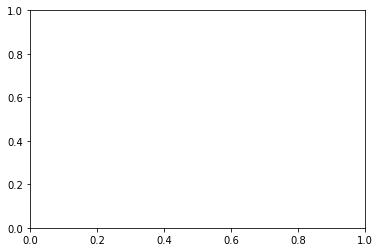

In [14]:
#Probemos
steps = 1000
generations = 3000
populationSize = 200
nMaps = 10
nTreasures = 6
mapSize = 10
#Creamos un darwin
darwin = Darwin(nMaps,mapSize,nTreasures)
darwin.initializePopulation(populationSize)
#%prun lastPuppet, bestScores,goat, goatScore = darwin.evolve(generations,steps)
lastPuppet, bestScores,goat, goatScore = darwin.evolve(generations,steps)

In [ ]:
3**(5)

#### print(bestScores[0])

(0.0, 600.0)

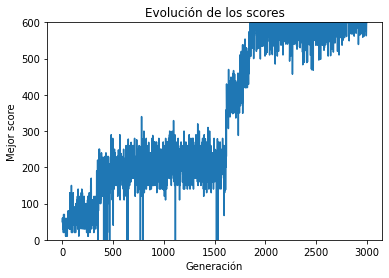

In [15]:

plt.figure()
plt.title("Evolución de los scores")
plt.plot(bestScores)
plt.xlabel("Generación")
plt.ylabel("Mejor score")
plt.ylim([0,600])

60


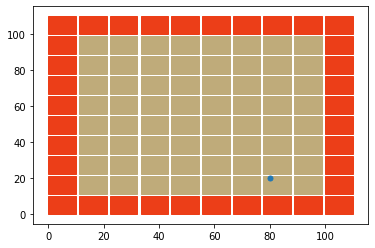

In [23]:
stage = Map(10,10)
stage.placeTreasures(6)
master = PuppetMaster()
master.obtainPlayAnimation(goat,stage,1000)


In [ ]:

stage = Map(10,10)
stage.placeTreasures(6)
master = PuppetMaster()
master.obtainPlayAnimation(goat,darwin.maps[8],100)

In [17]:
print(goat.genotype)

[6. 0. 3. 1. 0. 6. 0. 6. 2. 2. 2. 2. 1. 1. 2. 5. 3. 6. 3. 1. 3. 5. 6. 4.
 0. 1. 0. 3. 6. 6. 1. 0. 1. 3. 0. 3. 6. 6. 2. 6. 1. 2. 0. 6. 6. 3. 4. 0.
 2. 1. 1. 6. 6. 6. 2. 6. 1. 2. 0. 1. 5. 5. 2. 2. 3. 2. 2. 4. 2. 4. 1. 4.
 1. 1. 5. 6. 0. 5. 1. 4. 2. 4. 0. 4. 4. 6. 4. 1. 2. 3. 4. 6. 4. 4. 5. 1.
 4. 0. 4. 4. 5. 2. 2. 6. 6. 3. 1. 1. 4. 4. 3. 4. 3. 4. 3. 4. 2. 3. 6. 5.
 6. 3. 6. 4. 5. 2. 3. 5. 6. 2. 3. 0. 5. 3. 6. 4. 6. 4. 4. 1. 1. 1. 4. 5.
 0. 3. 4. 3. 2. 6. 4. 3. 3. 3. 6. 2. 6. 5. 2. 2. 0. 6. 5. 4. 4. 1. 4. 3.
 0. 0. 3. 6. 0. 6. 5. 6. 2. 5. 2. 3. 4. 5. 2. 5. 2. 6. 3. 5. 6. 1. 6. 2.
 3. 3. 3. 3. 3. 2. 1. 2. 6. 5. 4. 6. 2. 2. 4. 5. 3. 5. 0. 2. 6. 1. 2. 0.
 3. 0. 4. 2. 4. 5. 0. 3. 2. 6. 5. 0. 6. 1. 2. 5. 0. 2. 6. 2. 5. 4. 0. 5.
 1. 2. 6.]


In [ ]:
np.abs(np.max(a)-np.min(a))

In [ ]:
a = [1,2,3,4,5]
w = [0.9,0.02,0.02,0.02,0.04]
w2 = [np.nan,np.nan,np.nan,np.nan,np.nan]
random.choices(a,weights = w2)

In [ ]:
random.shuffle(a)
print(a)

In [ ]:
random.choice([0,1,2,3,4,5,6])

In [ ]:
random.randrange(0,200)

In [ ]:
a = np.array([1,2,3,4,5])
b = np.abs(a-14)/3
b[0:2] = [1,2]
print(b)

In [ ]:
a = np.array([1,2,3,4,5])
a = random.choices(a,k=4)
print(a)

In [ ]:
np.zeros(5)

In [ ]:
np.array(random.choices([0,1,2,3,4,5,6],k = 3**5))

In [ ]:
darwin.population[0].genotype

In [ ]:
darwin.population[2].genotype

In [ ]:
score =0

In [ ]:
score+=10
print(score)

In [ ]:
for i in range(0,10):
    print(darwin.population[i].genotype)

In [ ]:
CellType(2)

In [ ]:
a = 5

def proeba(x):
    x = x+4
    y = x
    return x

proeba(a)

In [ ]:
class objeto:
    a = 5
    
    def getA(self):
        return self.a
    
    def setA(self,a):
        self.a = a

In [ ]:
o = objeto()
y = o.a
x = o.getA()
o.setA(8)
print(x)
print(y)

In [60]:
2*3**0 +2*3**1  +2*3**2 +2*3**3+2*3**4

242

In [78]:
np.argmin([1,1,2,3])

0

In [13]:
goat.genotype

array([6., 1., 1., 6., 3., 1., 0., 6., 0., 2., 3., 1., 6., 0., 0., 5., 4.,
       4., 1., 0., 6., 5., 3., 0., 3., 0., 0., 3., 6., 2., 3., 5., 1., 5.,
       4., 0., 3., 5., 5., 6., 3., 2., 0., 4., 4., 3., 4., 4., 5., 5., 6.,
       2., 4., 3., 2., 2., 2., 0., 0., 3., 2., 1., 2., 0., 0., 3., 0., 5.,
       6., 5., 6., 1., 4., 4., 0., 5., 1., 3., 4., 4., 6., 4., 4., 3., 4.,
       1., 1., 2., 4., 0., 4., 0., 1., 1., 1., 5., 1., 4., 2., 5., 4., 0.,
       5., 0., 4., 0., 1., 2., 4., 3., 0., 3., 3., 6., 3., 5., 5., 1., 0.,
       5., 5., 0., 6., 0., 2., 0., 0., 5., 6., 4., 2., 4., 2., 0., 4., 4.,
       4., 5., 5., 5., 4., 6., 0., 1., 6., 1., 6., 5., 2., 4., 2., 3., 1.,
       2., 5., 4., 4., 3., 6., 5., 6., 6., 0., 1., 0., 0., 1., 3., 2., 3.,
       3., 5., 2., 2., 5., 3., 6., 6., 0., 6., 5., 6., 2., 5., 1., 6., 0.,
       2., 5., 6., 0., 1., 0., 5., 4., 0., 6., 2., 1., 3., 3., 0., 0., 1.,
       3., 4., 1., 6., 2., 1., 4., 0., 6., 1., 2., 1., 0., 5., 1., 4., 2.,
       1., 3., 2., 5., 4.